## Librerias Usadas

In [58]:
import os  # Interacción con el sistema operativo.

import numpy as np  # Manipulación de matrices y operaciones numéricas.
import pandas as pd  # Manipulación y análisis de datos tabulares.

import matplotlib.pyplot as plt  # Visualización de datos.
from mpl_toolkits.mplot3d import Axes3D  # Gráficos 3D.
import seaborn as sns  # Visualización estadística.

from sklearn.model_selection import train_test_split  # División de datos en entrenamiento y prueba.
from sklearn.cluster import KMeans  # Algoritmo de agrupamiento K-Means.
from sklearn import metrics  # Métricas de evaluación de modelos.

from surprise import Dataset, Reader, KNNBasic  # Biblioteca de recomendación de sistemas.
from collections import defaultdict

## Carga de los Datos

In [22]:
ratings_path = "ratings.csv"
movies_path = "movies.csv"

ratings_df = pd.read_csv(ratings_path)
movies_df = pd.read_csv(movies_path)

In [23]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [24]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Limpieza y Unión de los Conjuntos de Datos

In [25]:
ratings_df.drop(columns=['timestamp'], inplace=True)

In [26]:
df = pd.merge(ratings_df, movies_df, on='movieId', how='inner')

In [27]:
df.columns

Index(['userId', 'movieId', 'rating', 'title', 'genres'], dtype='object')

In [28]:
df.tail()

,userId,movieId,rating,title,genres
105334,668,142488,4.0,Spotlight (2015),Thriller
105335,668,142507,3.5,Pawn Sacrifice (2015),Drama
105336,668,143385,4.0,Bridge of Spies (2015),Drama|Thriller
105337,668,144976,2.5,Bone Tomahawk (2015),Horror|Western
105338,668,148626,4.5,The Big Short (2015),Drama


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   105339 non-null  int64  
 1   movieId  105339 non-null  int64  
 2   rating   105339 non-null  float64
 3   title    105339 non-null  object 
 4   genres   105339 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [30]:
df.drop_duplicates(inplace=True)

In [31]:
df.dropna(inplace=True)  # Eliminar filas con valores nulos


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   105339 non-null  int64  
 1   movieId  105339 non-null  int64  
 2   rating   105339 non-null  float64
 3   title    105339 non-null  object 
 4   genres   105339 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


## Visualización del Dataframe

Visualización de las calificaciones de las películas

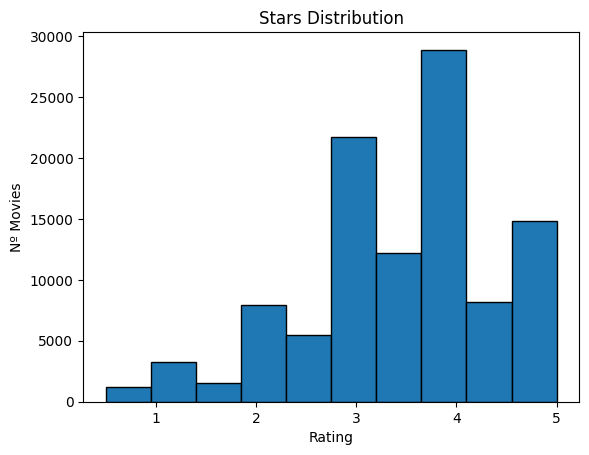

In [33]:
plt.hist(df['rating'], bins=10, edgecolor='black')  # Crea el histograma con 10 bins y bordes negros
plt.xlabel('Calificación')  # Etiqueta del eje x
plt.ylabel('Nº Películas')  # Etiqueta del eje y
plt.title('Distribución de Estrellas')  # Título del gráfico
plt.show()  # Muestra el histograma

Crea un gráfico de barras para visualizar el número de películas por género


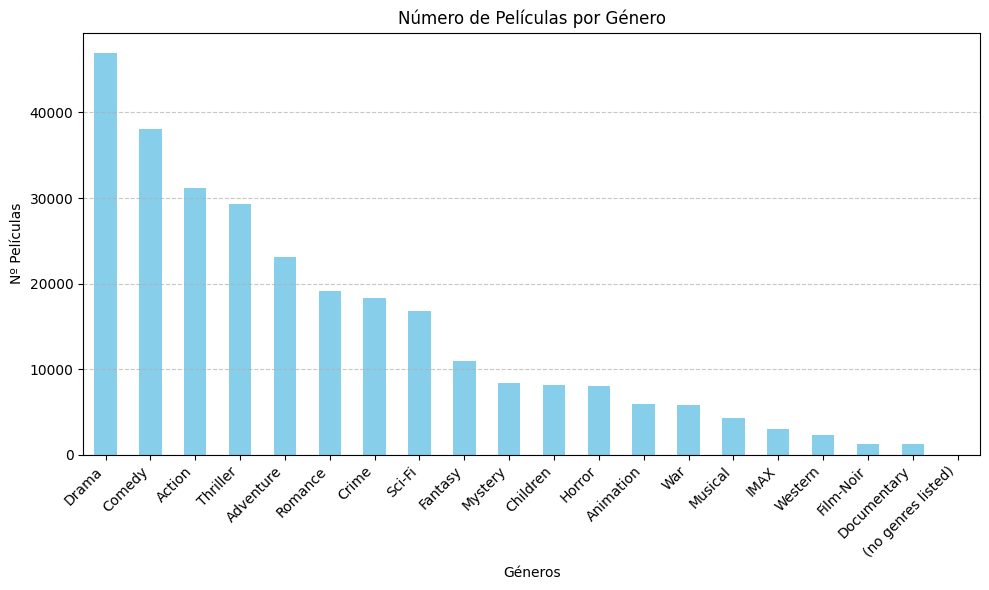

In [53]:
plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
genre_counts = df['genres'].str.split('|', expand=True).stack().value_counts()  # Cuenta el número de películas por género
genre_counts.plot(kind='bar', color='skyblue')  # Crea el gráfico de barras
plt.xlabel('Géneros')  # Etiqueta del eje x
plt.ylabel('Nº Películas')  # Etiqueta del eje y
plt.title('Número de Películas por Género')  # Título del gráfico
plt.xticks(rotation=45, ha='right')  # Ajusta la orientación de las etiquetas del eje x
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agrega líneas de cuadrícula en el eje y
plt.tight_layout()  # Ajusta el diseño del gráfico
plt.show()  # Muestra el gráfico


Visualización de las 10 Películas con Más Calificaciones

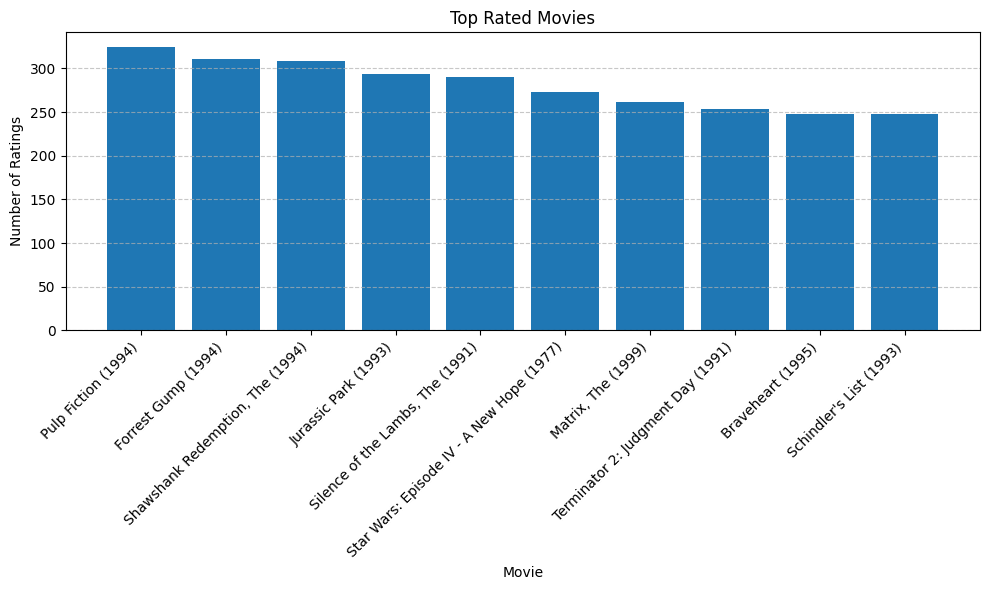

In [15]:
plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
top_movies = df.groupby('title')['rating'].count().nlargest(10)  # Obtiene las 10 películas con más calificaciones
plt.bar(top_movies.index, top_movies)  # Crea el gráfico de barras
plt.xticks(rotation=45, ha='right')  # Ajusta la orientación de las etiquetas del eje x
plt.xlabel('Película')  # Etiqueta del eje x
plt.ylabel('Número de Calificaciones')  # Etiqueta del eje y
plt.title('Top 10 Películas con Más Calificaciones')  # Título del gráfico
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agrega líneas de cuadrícula en el eje y
plt.tight_layout()  # Ajusta el diseño del gráfico
plt.show()  # Muestra el gráfico

Visualización de las 10 Películas con la Calificación Promedio Más Alta

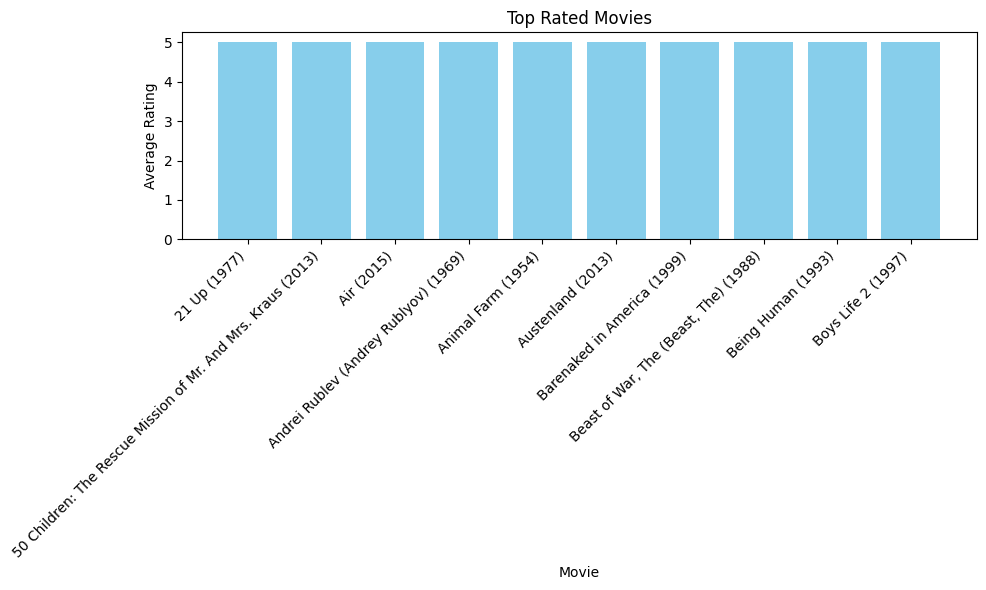

In [35]:
# Calcula el promedio de las calificaciones para cada película
avg_ratings = df.groupby('title')['rating'].mean()

# Selecciona las 10 películas con la calificación promedio más alta
top_rated_movies = avg_ratings.nlargest(10)

# Crea el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(top_rated_movies.index, top_rated_movies.values, color='skyblue')

# Ajusta las etiquetas del eje x para una mejor legibilidad
plt.xticks(rotation=45, ha='right')

# Etiqueta los ejes y el título
plt.xlabel('Movie')
plt.ylabel('Average Rating')
plt.title('Top Rated Movies')

# Muestra el gráfico
plt.tight_layout()
plt.show()

In [17]:
df.head()

,userId,movieId,rating,title,genres
0,1,16,4.0,Casino (1995),Crime|Drama
1,1,24,1.5,Powder (1995),Drama|Sci-Fi
2,1,32,4.0,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,4.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,4.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


Selección de Características Relevantes del DataFrame

In [37]:
df_new = df[['userId', 'movieId', 'rating']]
df_new.head()

,userId,movieId,rating
0,1,16,4.0
1,1,24,1.5
2,1,32,4.0
3,1,47,4.0
4,1,50,4.0


División del Conjunto de Datos en Conjuntos de Entrenamiento y Prueba

In [39]:
from sklearn.model_selection import train_test_split
# Splitting the DataFrame into training and testing sets
X_train, X_test = train_test_split(df_new, test_size=0.2, random_state=42)

# Displaying the first few rows of the training set
X_train.head()

,userId,movieId,rating
93148,614,1884,4.0
17873,137,55290,4.0
46130,328,2028,3.0
70228,475,61075,3.5
10717,89,597,3.0


Entrenamiento del Modelo de KMeans y Asignación de Clústeres

In [40]:
model = KMeans(n_clusters = 6, n_init = "auto", random_state = 42)
model.fit(X_train)

y_train = list(model.labels_)
X_train["cluster"] = y_train
X_train.head()

,userId,movieId,rating,cluster
93148,614,1884,4.0,0
17873,137,55290,4.0,1
46130,328,2028,3.0,0
70228,475,61075,3.5,1
10717,89,597,3.0,0


Visualización de Datos en Gráficos de Dispersión por Clúster


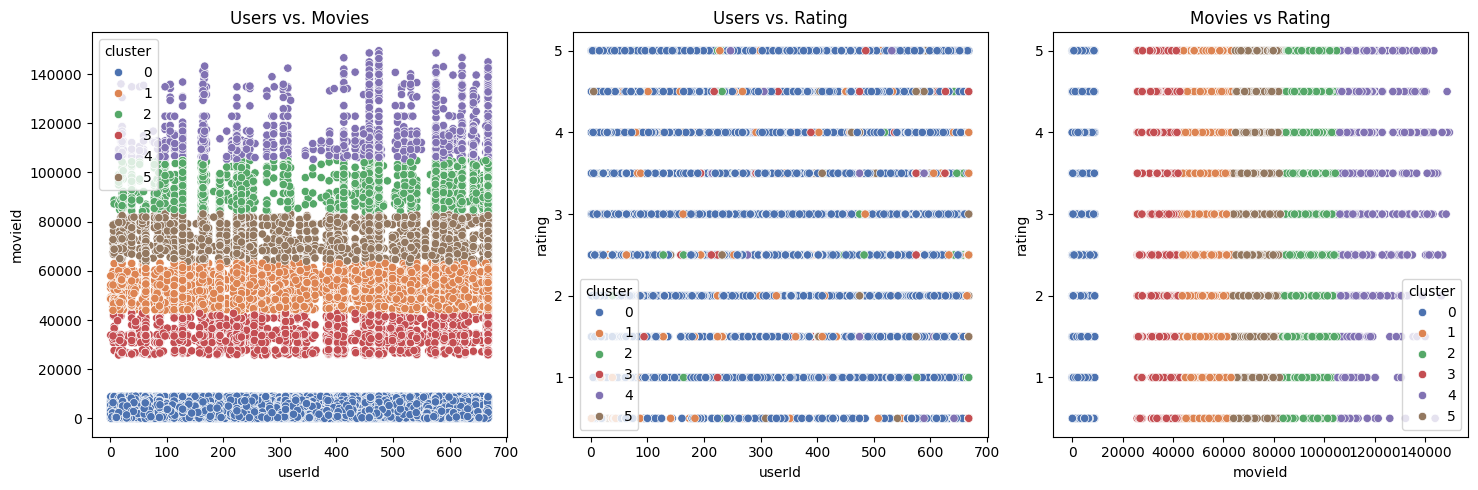

In [43]:
fig, axis = plt.subplots(1, 3, figsize=(15, 5))

# Gráfico de dispersión userId vs. movieId
sns.scatterplot(ax=axis[0], data=X_train, x="userId", y="movieId", hue="cluster", palette="deep")
axis[0].set_title("Users vs. Movies")

# Gráfico de dispersión userId vs. rating
sns.scatterplot(ax=axis[1], data=X_train, x="userId", y="rating", hue="cluster", palette="deep")
axis[1].set_title("Users vs. Rating")

# Gráfico de dispersión movieId vs. rating
sns.scatterplot(ax=axis[2], data=X_train, x="movieId", y="rating", hue="cluster", palette="deep")
axis[2].set_title("Movies vs Rating")

plt.tight_layout()
plt.show()


Visualización de Clústeres en un Gráfico 3D

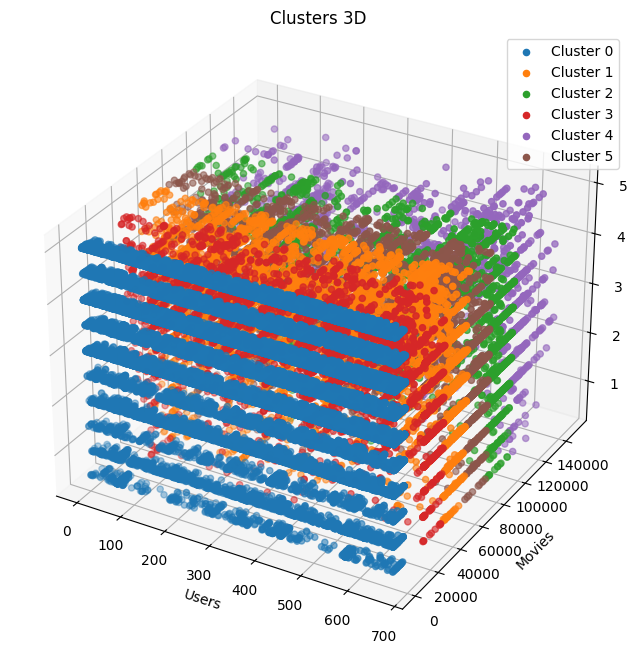

In [46]:
# Crear una figura y un conjunto de ejes tridimensionales
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Iterar sobre cada clúster y visualizarlo en el gráfico 3D
for cluster_label in range(6):
    cluster_data = X_train[X_train["cluster"] == cluster_label]
    ax.scatter(cluster_data["userId"], cluster_data["movieId"], cluster_data["rating"], label=f'Cluster {cluster_label}')

# Etiquetas de los ejes
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
ax.set_zlabel('Ratings')

# Título del gráfico
plt.title('Clusters 3D')

# Leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Generación de Recomendaciones de Películas para un Usuario Específico

Este código genera recomendaciones de películas para un usuario específico basado en un modelo K-Means previamente entrenado.
Las recomendaciones se basan en las películas más relevantes dentro del clúster al que pertenece el usuario, excluyendo aquellas que el usuario ya ha visto.

In [61]:
# Obtener las películas más relevantes para cada clúster
cluster_center_movies = defaultdict(list)
for cluster_label in range(6):  # Itera sobre cada clúster
    # Filtra los datos de entrenamiento para el clúster actual
    cluster_data = X_train[X_train["cluster"] == cluster_label]
    # Encuentra las películas más frecuentes en el clúster y selecciona las 10 principales
    top_movies = cluster_data.groupby("movieId").size().sort_values(ascending=False).index[:10]
    # Almacena las 10 películas más relevantes para el clúster en el diccionario
    cluster_center_movies[cluster_label] = top_movies

# Función para generar recomendaciones para un usuario específico
def get_user_recommendations(user_id):
    # Filtra los datos de entrenamiento para el usuario específico
    user_data = X_train[X_train["userId"] == user_id]
    # Obtiene el clúster al que pertenece el usuario
    user_cluster = user_data["cluster"].iloc[0]
    # Obtiene las películas más relevantes para el clúster del usuario
    cluster_movies = cluster_center_movies[user_cluster]
    # Obtiene las películas que el usuario ya ha visto
    watched_movies = set(user_data["movieId"])
    # Genera recomendaciones excluyendo las películas que el usuario ya ha visto y selecciona las 5 principales
    recommendations = [movie_id for movie_id in cluster_movies if movie_id not in watched_movies][:5]
    return recommendations

# Función para obtener el título de la película a partir de su ID
def get_movie_title(movie_id):
    return df[df["movieId"] == movie_id]["title"].iloc[0]


In [62]:
# Usuario para el que deseas generar recomendaciones
user_id_to_recommend = 9  # UserID que quieras ver

# Obtener las películas que el usuario ha visto
watched_movies = set(X_train[X_train["userId"] == user_id_to_recommend]["movieId"])

# Generar recomendaciones para el usuario especificado
recommendations = get_user_recommendations(user_id_to_recommend)

# Filtrar las recomendaciones para incluir solo películas que el usuario aún no ha visto
filtered_recommendations = [get_movie_title(movie_id) for movie_id in recommendations if movie_id not in watched_movies]

# Mostrar las recomendaciones para el usuario especificado
print(f"Recomendaciones para el usuario {user_id_to_recommend}: {filtered_recommendations}")

Recomendaciones para el usuario 9: ['Jurassic Park (1993)', 'Silence of the Lambs, The (1991)', 'Matrix, The (1999)', 'Terminator 2: Judgment Day (1991)']
